# Link prediction 

## Import necessary modules 

In [1]:
import networkx as nx
from networkx.classes.function import info

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from tqdm import tqdm
import multiprocessing

from gensim.models import Word2Vec
from gensim.models import KeyedVectors, Word2Vec

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import EdgeSplitter

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Data importation and preprocessing

### Edge data

In [2]:
edges = pd.read_csv('git_edges.csv')
edges.head()

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [3]:
edges.shape

(289003, 2)

### Node data

In [4]:
nodes = pd.read_csv('git_nodes.csv')
nodes.head()

,id,name,developer_type
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [5]:
nodes['developer_type'].unique() #binary classified 

array([0, 1], dtype=int64)

In [6]:
nodes.shape

(37700, 3)

## Load, sample, and process data 
We can sample the graph and remove unsampled, isolated, and barely connected nodes.

In [7]:
def load_graph(edges, nodes):
    G = nx.from_pandas_edgelist(edges, 'id_1', 'id_2') #networkx object
    
    # set node attribute
    nx.set_node_attributes(G, pd.Series(nodes.developer_type, index=nodes.id).to_dict(), 'developer_type')
    nx.set_node_attributes(G, pd.Series(nodes.id, index=nodes.id).to_dict(), 'id')

    return G

def sample_graph(G, num_samples, seed):
    # randomly sample data 
    random.seed(seed) #set random state for next occurance of random elements
    samples = random.sample(list(G.nodes), num_samples)
    
    # remove unsampled nodes
    dump_nodes = []
    for n in tqdm(G):
        if n not in samples:
            dump_nodes.append(n)       
    G.remove_nodes_from(dump_nodes)
    print("Number of sampled nodes(with isolates and small components):", len(list(G.nodes)))
    
    # remove isolates (nodes with no edges)
    G.remove_nodes_from(list(nx.isolates(G)))
    print("Number of sampled nodes(with isolates removed):", len(list(G.nodes)))
    
    # remove barely connected nodes
    for component in list(nx.connected_components(G)):
        if len(component)<7:
            for node in component:
                G.remove_node(node)
    print("Number of sampled nodes(with small components removed):", len(list(G.nodes)))
    
    return G

In [8]:
G = load_graph(edges, nodes) #return as networkx graph
G = sample_graph(G, 5000, 0) #return as stellarGraph

100%|██████████████████████████████████████████████████████████████████████████| 37700/37700 [00:03<00:00, 9910.71it/s]


Number of sampled nodes(with isolates and small components): 5000
Number of sampled nodes(with isolates removed): 2876
Number of sampled nodes(with small components removed): 2706


In [9]:
info(G)

'Graph with 2706 nodes and 5182 edges'

## Visuailze graph

In [10]:
def vis_graph(G):
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G, scale=11)
    node_colours = [G.nodes[id]['developer_type'] for id in G.nodes]
    nx.draw(G,pos,node_size=9, node_color=node_colours)

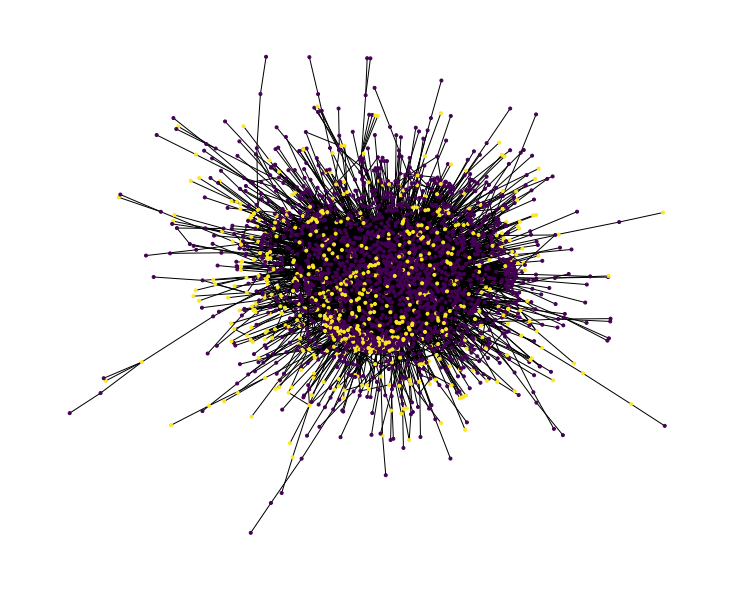

In [11]:
vis_graph(G) 

## Test graph 
We begin with the __full graph__ and use the `EdgeSplitter` class to produce:
- Test Graph
- Test set of positive/negative link examples for model evaluation

The Test Graph is the reduced graph we obtain from removing the test set of links from the full graph.


In [12]:
def test_graph(G):
    # Define an edge splitter on the original graph:
    edge_splitter_test = EdgeSplitter(G)

    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, 
    # from graph, and obtain the reduced graph `graph_test` with the sampled links removed:
    graph_test, X_test, y_test = edge_splitter_test.train_test_split(
        p=0.1, method="global"
    )
    return graph_test, X_test, y_test

In [13]:
graph_test, X_test, y_test = test_graph(G)

** Sampled 518 positive and 518 negative edges. **


In [14]:
info(graph_test)

'Graph with 2706 nodes and 4664 edges'

## Train graph 
This time, we use the `EdgeSplitter` on the __Test Graph__, and perform a train/test split on the examples to produce:
- Train Graph
- Training set of link examples 
- Test set for model selection

Set of link examples for model selection

In [15]:
def train_graph(graph_test, G):
    # Repeat the process on the test graph:
    edge_splitter_test = EdgeSplitter(graph_test, G)
    graph_train, X, y = edge_splitter_test.train_test_split(
        p=0.1, method="global"
    )
    
    # Split data into training set and model selection test set
    X_train, X_testmodel, y_train, y_testmodel = train_test_split(
        X, y, train_size=0.75, test_size=0.25
    )
    return graph_train, X_train, X_testmodel, y_train, y_testmodel

In [16]:
graph_train, X_train, X_testmodel, y_train, y_testmodel = train_graph(graph_test,G)

** Sampled 466 positive and 466 negative edges. **


In [17]:
info(graph_train)

'Graph with 2706 nodes and 4198 edges'

## Summary of splits of graph 
We have to carefully split the data to avoid data leakage and evaluate the algorithms correctly:
- For computing node embeddings, a Train Graph (`graph_train`)
- For training classifiers, a classifier Training Set (`X_train`) of positive and negative edges that weren’t used for computing node embeddings
- For choosing the best classifier, an Model Selection Test Set (`X_testmodel`) of positive and negative edges that weren’t used for computing node embeddings or training the classifier
- For the final evaluation, a Test Graph (`graph_test`) to compute test node embeddings with more edges than the Train Graph, and a Test Set (`X_test`) of positive and negative edges not used for neither computing the test node embeddings or for classifier training or model selection

In [18]:
pd.DataFrame(
    [
        (
            "Train Graph",
            len(graph_train),
            "-",
            "Test Graph",
            "Train node embeddings model",
        ),
         (
            "Test Graph",
            len(graph_test),
            "-",
            "Full Graph",
            "Test node embeddings model",
        ),
        (
            "Train Set",
            len(X_train),
            "Train Graph",
            "Test Graph",
            "Train link classifier model",
        ),
        (
            "Model Selection Set",
            len(X_testmodel),
            "Train Graph",
            "Test Graph",
            "Select link classifier model",
        ),
         (
            "Test set",
            len(X_test),
            "Test Graph",
            "Full Graph",
            "Test link classifier model",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Train Graph,2706,-,Test Graph,Train node embeddings model
Test Graph,2706,-,Full Graph,Test node embeddings model
Train Set,699,Train Graph,Test Graph,Train link classifier model
Model Selection Set,233,Train Graph,Test Graph,Select link classifier model
Test set,1036,Test Graph,Full Graph,Test link classifier model


## Node2Vec model 
We use Node2Vec, to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.

In [19]:
# helper function 
def load_embeddings(file_path):
    embedding_dict = {}
    first_line = True
    with open(file_path) as f:
        for line in f:
            if first_line:
                first_line = False
                continue
            vector = [float(i) for i in line.strip().split()]
            embedding_dict[int(vector[0])] = vector[1:]
        f.close()
    return embedding_dict

# two steps Node2Vec algorithm
def calculate_embeddings(recalculate_embeddings, G, txt_embeddings_file_path):
    if recalculate_embeddings==True: #calculate emebeddings, or else use existing ones
        '''1. perform random walk to generate corpus'''
        rw = BiasedRandomWalk(StellarGraph.from_networkx(G))
        walks = rw.run(
            nodes=list(G.nodes()),  # root nodes
            length=32, #maximum length of a random walk
            n=10, #number of random walks per root node
            p=1, #Defines (unormalised) probability, 1/p, of returning to source node
            q=1, #Defines (unormalised) probability, 1/q, for moving away from source node
        )
        print("Number of random walks: {}".format(len(walks))) #only print when recalculate embeddings 
        
        '''2. form Word2Vec to learn embedding vectors and save as .txt'''
        str_walks = [[str(n) for n in walk] for walk in walks] #str conversion for Word2Vec argument
        model = Word2Vec(
            str_walks, 
            vector_size=128, 
            window=5,       
            min_count=0, 
            sg=1, 
            workers=multiprocessing.cpu_count(), 
            epochs=1)
        model.wv.save_word2vec_format(txt_embeddings_file_path) #save to path as .txt
        
    return load_embeddings(txt_embeddings_file_path)

In [20]:
embeddings = calculate_embeddings(True, graph_train, 'embeddings.txt') #if False, use existing embeddings

Number of random walks: 27060


## Visualize embeddings

In [21]:
def vis_node_embeddings(G, embeddings_path):
    # Retrieve node embeddings and corresponding subjects(page type)
    model = KeyedVectors.load_word2vec_format(embeddings_path)  
    node_ids = model.index_to_key #list of node ids(in str)
    node_embeddings = model.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
    node_targets = [G.nodes[int(node_id)]['developer_type'] for node_id in node_ids]
    
    # Apply dimension reduction on node embeddings - PCA
    pca = PCA(n_components=2)
    node_embeddings_2d = pca.fit_transform(node_embeddings)
    
    # visualization
    label_map = {label: idx for idx, label in enumerate(np.unique(node_targets))}
    node_colours = [label_map[target] for target in node_targets]
    plt.figure(figsize=(10,8))
    plt.scatter(node_embeddings_2d[:,0],
                node_embeddings_2d[:,1],
                c=node_colours, alpha=0.9)
    plt.show()

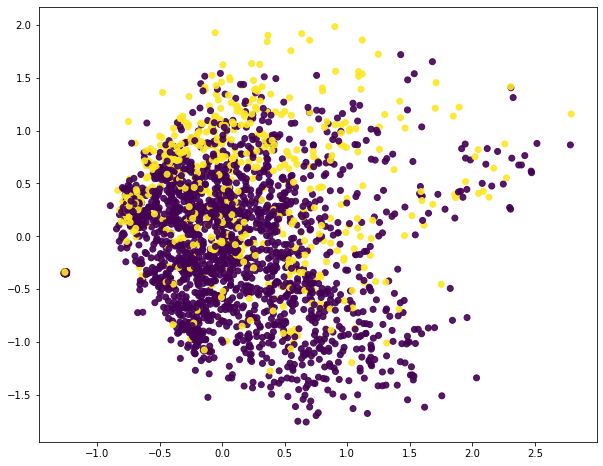

In [22]:
vis_node_embeddings(G, 'embeddings.txt')

## Link prediction model with best operator
There are a few steps involved in using the Word2Vec model to perform link prediction: 
1. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge. 
2. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict a binary value indicating whether an edge between two nodes should exist or not. 
3. We evaluate the performance of the link classifier for each of the 4 operators on the training data with node embeddings calculated on the Train Graph (`graph_train`), and select the best classifier. 

In [23]:
# 1. link embeddings
def link_examples_to_features(X_train, embeddings, binary_operator):
    return [
        binary_operator(embeddings[src], embeddings[dst])
        for src, dst in X_train
    ]

def link_prediction_classifier():
    lr_clf = LogisticRegressionCV(Cs=100, cv=10, scoring="roc_auc", max_iter=3000, n_jobs=-1)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

# 2. train classifier
def train_classifier(X_train, y_train, embeddings, binary_operator):
    clf = link_prediction_classifier()
    X_features = link_examples_to_features(
        X_train, embeddings, binary_operator
    )
    clf.fit(X_features, y_train)
    return clf

# 3. evaluate classifier
def evaluate_roc_auc(clf, X_features, y_test):
    predicted = clf.predict_proba(X_features)
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(y_test, predicted[:, positive_column])

# 4. find the best model 
def evaluate_model(X_test, y_test, embeddings, binary_operator, clf):
    X_features = link_examples_to_features(
        X_test, embeddings, binary_operator
    )
    score = evaluate_roc_auc(clf, X_features, y_test)
    #print(f"ROC AUC score: {score}")
    return score 

In [24]:
def operator_hadamard(u, v):
    u = np.array(u)
    v = np.array(v)
    return u * v

def operator_l1(u, v):
    u = np.array(u)
    v = np.array(v)
    return np.abs(u - v)

def operator_l2(u, v):
    u = np.array(u)
    v = np.array(v)
    return (u - v) ** 2

def operator_avg(u, v):
    u = np.array(u)
    v = np.array(v)
    return (u + v) / 2.0

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [25]:
def best_model(X_train, y_train, X_testmodel, y_testmodel, embeddings,op):
    clf = train_classifier(X_train, y_train, embeddings, op)
    score = evaluate_model(X_testmodel, y_testmodel, embeddings, op, clf)
                           
    return {
        "classifier":clf,
        "binary operator":op,
        "score":score
    }

In [26]:
results = [best_model(X_train, y_train, X_testmodel, y_testmodel,embeddings, op) 
               for op in binary_operators]

In [27]:
best_result = max(results, key=lambda result: result["score"])
print(f"Best result:'{best_result['binary operator'].__name__}'")

pd.DataFrame(
    [(result["binary operator"].__name__, result["score"]) for result in results],
    columns=("Operator", "ROC AUC score"),
).set_index("Operator")

Best result:'operator_avg'


,ROC AUC score
Operator,
operator_hadamard,0.690293
operator_l1,0.708494
operator_l2,0.728988
operator_avg,0.741788


## Evaluate the best model using the test set 
The best classifier is then used to calculate scores on the test data. 

In [28]:
test_score = evaluate_model(
    X_test,
    y_test,
    embeddings,
    best_result["binary operator"],
    best_result["classifier"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_avg': 0.7376529866877359
